In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment


n_attackers = 3
m_defenders = 4
T = 50  # Time steps
alpha, beta, gamma = 1.0, 2.5, 3.0

# Generate Attacker Trajectories
t_vals = np.linspace(0, 1, T)
attackers = np.zeros((T, n_attackers, 2))

attackers[:, 0, :] = np.column_stack((70 + 10 * np.sin(2 * np.pi * t_vals), 20 + 10 * t_vals))
attackers[:, 1, :] = np.column_stack((75 + 8 * np.sin(2 * np.pi * t_vals), 32 + 8 * t_vals))
attackers[:, 2, :] = np.column_stack((80 + 6 * np.sin(2 * np.pi * t_vals), 44 + 6 * t_vals))

# Defender Initial Positions
initial_defenders = np.array([
    [60, 25],
    [62, 35],
    [64, 45],
    [66, 55]
])

# Threat Function
def threat(pos):
    return np.exp(-0.05 * pos[1])  # Higher threat near goal (y=0)


# Simulation Function
def simulate(strategy='greedy'):
    defender_trajs = np.zeros((T, m_defenders, 2))
    defender_trajs[0] = initial_defenders
    prev_assignment = [-1] * m_defenders
    assignments = np.full((T, m_defenders), -1)
    total_costs = []
    switch_count = 0

    for t in range(T):
        cost_matrix = np.zeros((m_defenders, n_attackers))

        # Construct cost matrix
        for i in range(m_defenders):
            for j in range(n_attackers):
                prev_pos = initial_defenders[i] if t == 0 else defender_trajs[t-1, i]
                dist = np.linalg.norm(prev_pos - attackers[t, j])
                threat_level = threat(attackers[t, j])

                # Strategy-dependent switching penalty
                if strategy == 'greedy':
                    switch_penalty = 0
                elif strategy == 'dp':
                    switch_penalty = gamma if prev_assignment[i] != j else 0
                elif strategy == 'continuous':
                    switch_penalty = 0  
                else:
                    raise ValueError("Unknown strategy")

                cost_matrix[i, j] = alpha * dist + beta * threat_level + switch_penalty

        # Hungarian algorithm for optimal assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        cost_sum = 0
        for i, j in zip(row_ind, col_ind):
            assignments[t, i] = j
            if strategy == 'dp' and prev_assignment[i] != j and t > 0:
                switch_count += 1
            prev_assignment[i] = j

            # Update defender position
            if t == 0:
                defender_trajs[t, i] = initial_defenders[i]
            else:
                dir_vec = attackers[t, j] - defender_trajs[t-1, i]
                step_size = 0.3 if strategy != 'continuous' else 0.15
                defender_trajs[t, i] = defender_trajs[t-1, i] + step_size * dir_vec

            cost_sum += cost_matrix[i, j]

        total_costs.append(cost_sum)

    return defender_trajs, np.array(total_costs), switch_count

# Run Simulation for All Strategies
results = {}
for strat in ['greedy', 'dp', 'continuous']:
    trajs, costs, switches = simulate(strategy=strat)
    results[strat] = {
        'trajs': trajs,
        'costs': costs,
        'switches': switches,
        'total_cost': np.sum(costs)
    }

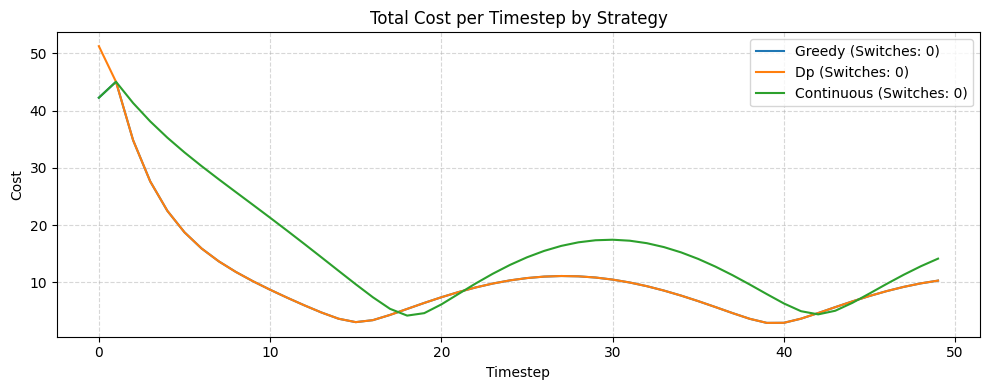

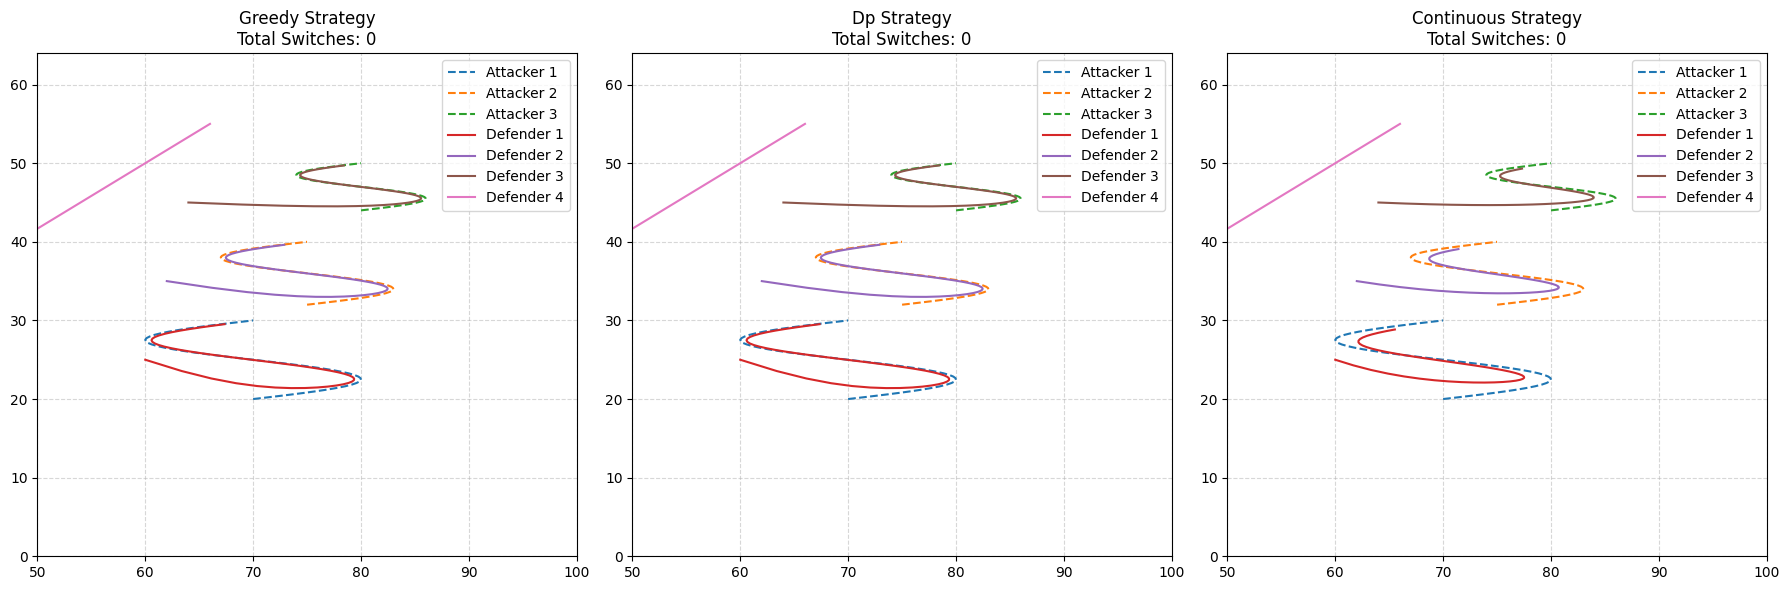

=== Strategy Summary ===
Greedy Strategy:
  Total Cost: 534.49
  Total Switches: 0

Dp Strategy:
  Total Cost: 543.49
  Total Switches: 0

Continuous Strategy:
  Total Cost: 808.42
  Total Switches: 0



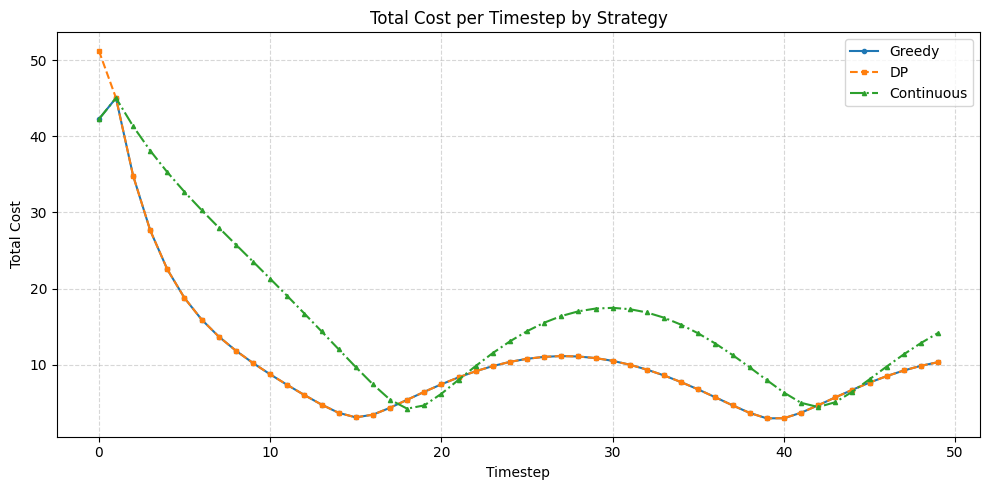

In [3]:

import pandas as pd
# Plot: Total Cost Over Time
plt.figure(figsize=(10, 4))
for strat in results:
    label = f"{strat.capitalize()} (Switches: {results[strat]['switches']})"
    plt.plot(results[strat]['costs'], label=label)
plt.title("Total Cost per Timestep by Strategy")
plt.xlabel("Timestep")
plt.ylabel("Cost")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot: Trajectories of All Strategies
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for idx, strat in enumerate(['greedy', 'dp', 'continuous']):
    ax = axs[idx]
    ax.set_xlim(50, 100)
    ax.set_ylim(0, 64)
    ax.set_title(f"{strat.capitalize()} Strategy\nTotal Switches: {results[strat]['switches']}")
    for j in range(n_attackers):
        ax.plot(attackers[:, j, 0], attackers[:, j, 1], '--', label=f'Attacker {j+1}')
    for i in range(m_defenders):
        ax.plot(results[strat]['trajs'][:, i, 0], results[strat]['trajs'][:, i, 1], label=f'Defender {i+1}')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# -----------------------------
# Print Summary Table
# -----------------------------
print("=== Strategy Summary ===")
for strat in ['greedy', 'dp', 'continuous']:
    print(f"{strat.capitalize()} Strategy:")
    print(f"  Total Cost: {results[strat]['total_cost']:.2f}")
    print(f"  Total Switches: {results[strat]['switches']}")
    print()



# Create a DataFrame for timestep-wise cost comparison
T = len(results['greedy']['costs'])  # Number of time steps
cost_df = pd.DataFrame({
    'Timestep': np.arange(T),
    'Greedy': results['greedy']['costs'],
    'DP': results['dp']['costs'],
    'Continuous': results['continuous']['costs']
})

# Plotting the cost per timestep for each strategy
plt.figure(figsize=(10, 5))
plt.plot(cost_df['Timestep'], cost_df['Greedy'], label='Greedy', linestyle='-', marker='o', markersize=3)
plt.plot(cost_df['Timestep'], cost_df['DP'], label='DP', linestyle='--', marker='s', markersize=3)
plt.plot(cost_df['Timestep'], cost_df['Continuous'], label='Continuous', linestyle='-.', marker='^', markersize=3)

# Labeling
plt.title('Total Cost per Timestep by Strategy')
plt.xlabel('Timestep')
plt.ylabel('Total Cost')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
